#Analyzing Injury Risk for Baseball Pitch with Machine Learning

Author: Siddharth Sharma

In this notebook, we'll use the Video Intelligence API to analyze a baseball pitch. We will also deduce orthopedic injury risk (joint stress).

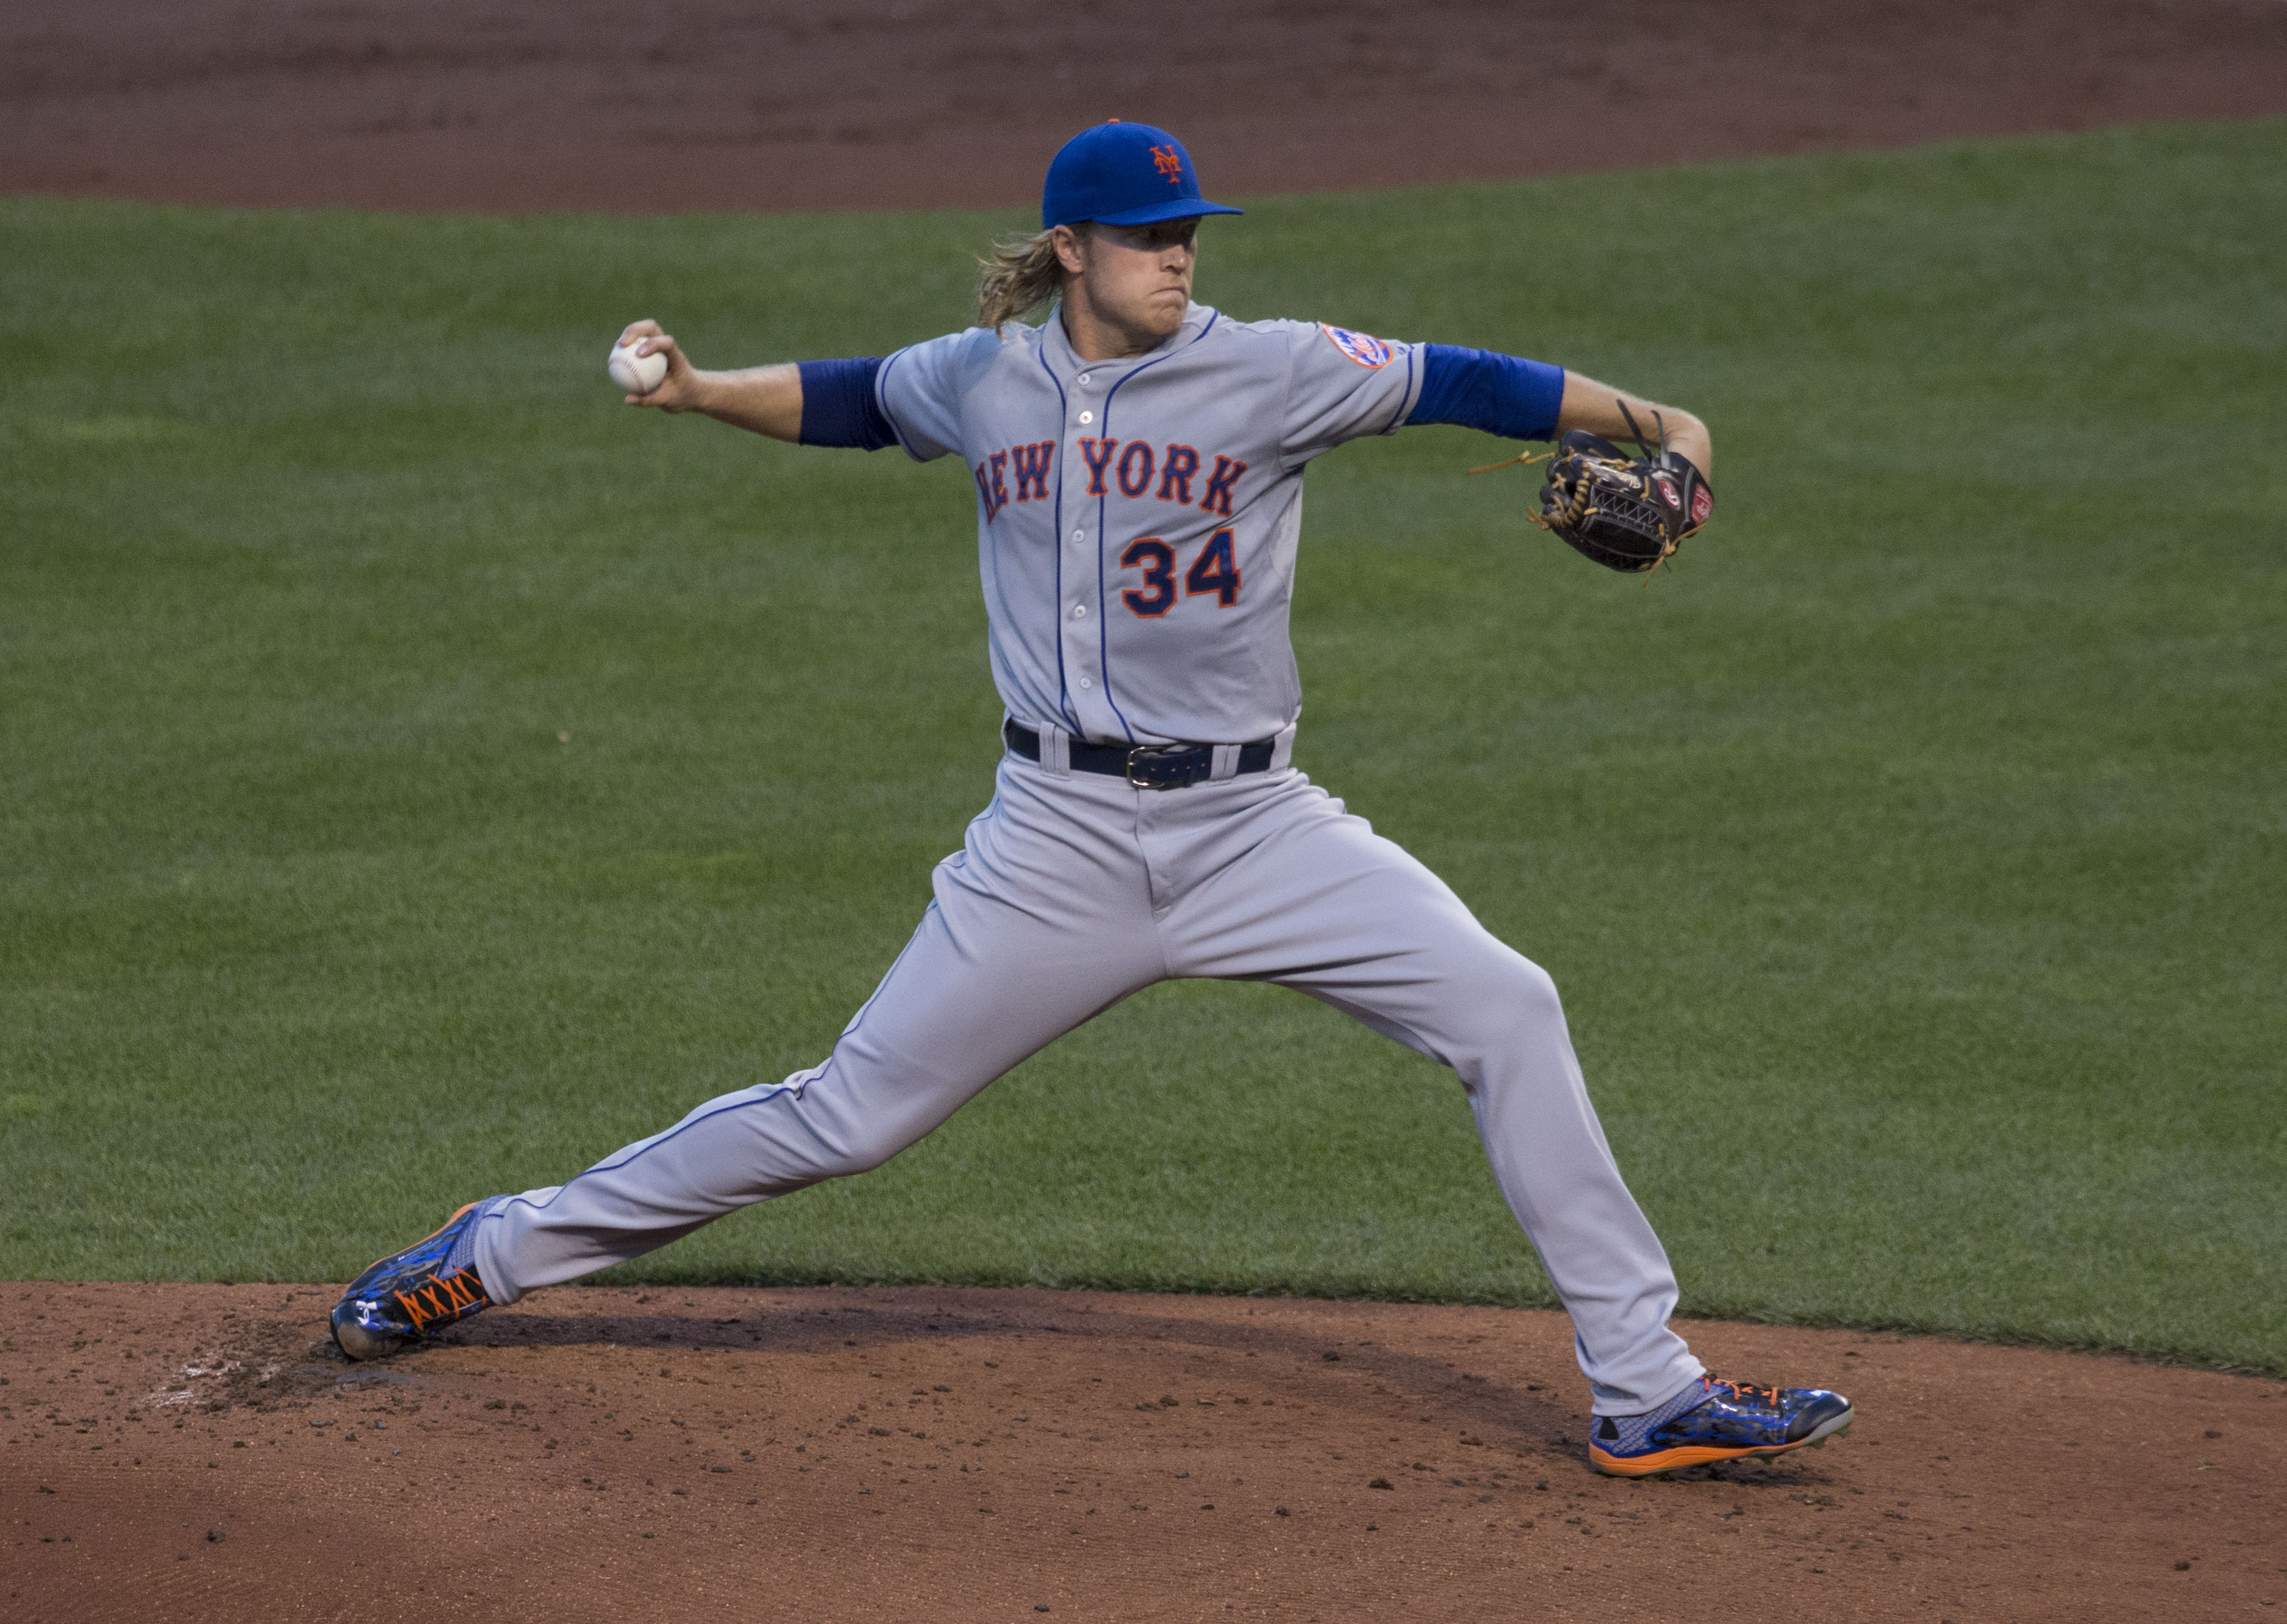



##Setup

First, let's install the libraries. This first cell will download and install the libraries on our colab virtual machine, and the next cell imports them.

In [ ]:
# useful links: https://stackoverflow.com/questions/16841729/how-do-i-compute-the-derivative-of-an-array-in-python (for taking derivative of an array)

In [ ]:
!pip install google-cloud-automl
!apt-get install libmagickwand-dev
!pip install pillow
!pip install --upgrade protobuf
!pip install --upgrade google-cloud-videointelligence

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmagickwand-dev is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.8).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Requirement already up-to-date: protobuf in /usr/local/lib/python3.6/dist-packages (3.13.0)
Requirement already up-to-date: google-cloud-videointelligence in /usr/local/lib/python3.6/dist-packages (1.15.0)


You might have to restart your runtime to load these packages.

In [ ]:
import sys
import os
import json
import math

from google.colab import auth
from google.colab import files

import pandas as pd
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import numpy as np

from google.cloud import automl
from google.cloud import videointelligence_v1p3beta1 as videointelligence
from google.oauth2 import service_account

Next, create a new GCP account (if you don't have one already), and create a new project. 

In [ ]:
auth.authenticate_user()

Fill in your info below by specifying your project id. You'll also need to choose a bucket name (that should start with `gs://`) and a name for your service account, a file that will be downloaded to this notebook to allow us to use the AutoML API. `service_account_name` can be anything.

In [ ]:
# TODO: REMOVE MY SPECIFIC CONFIG
project_id = 'round-exchange-287916'  #@param {type: "string"}
bucket = 'gs://bucketsid0116' #@param {type: "string"}
service_account_name="sidnewtest" #@param {type: "string"}

In [ ]:
!gcloud config set project {project_id}
!gsutil mb {bucket}
!gcloud iam service-accounts create {service_account_name}
!gcloud iam service-accounts keys create ./key.json --iam-account {service_account_name}@{project_id}.iam.gserviceaccount.com

# Enable the Video Intelligence API and AutoML
!gcloud services enable videointelligence.googleapis.com
!gcloud services enable automl.googleapis.com

# Give your service account permission to access the API
!gcloud projects add-iam-policy-binding {project_id} --member="serviceAccount:{service_account_name}@{project_id}.iam.gserviceaccount.com" --role="roles/editor"

Updated property [core/project].
Creating gs://bucketsid0116/...
ServiceException: 409 Bucket bucketsid0116 already exists.
Created service account [sidnewtest].
created key [669732d1109d8ae5b055427995583136dc53fe0c] of type [json] as [./key.json] for [sidnewtest@round-exchange-287916.iam.gserviceaccount.com]
Operation "operations/acf.c8420a68-3948-4f54-b3c7-13ea5df7467c" finished successfully.
Operation "operations/acf.85b75390-902e-454f-acd8-1f047d183e6c" finished successfully.
Updated IAM policy for project [round-exchange-287916].
bindings:
- members:
  - serviceAccount:sidnewtest@round-exchange-287916.iam.gserviceaccount.com
  role: roles/editor
- members:
  - user:siddrrshcollege@gmail.com
  role: roles/owner
etag: BwWuBuKmaus=
version: 1


In [ ]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./key.json"

##Using the Video Intelligence API

We will now upload a single person view of a baseball pitch motion. In this bit, we'll analyze our skeletons using the Video Intelligence API. The API tracks all sorts of features, including features of the face, but we'll just focus on the body:

To do this, you'll need to upload a video you'd like to analyze to a cloud storage bucket. The fastest way to do this is from the command line: `gsutil cp YOUR_VIDEO_FILE.mp4 gs://YOUR_BUCKET_NAME`. Fill in the name of the file you upload here:

In [ ]:
!gsutil cp pitch1.mp4 gs://bucket

Copying file://pitch1.mp4 [Content-Type=video/mp4]...
AccessDeniedException: 403 siddrrshcollege@gmail.com does not have storage.objects.create access to bucket/pitch1.mp4.


In [ ]:
file_to_analyze = 'pitch1.mp4' #@param {type: "string"}

In [ ]:
# Verify that you see that file listed here... 
# This cell should print the name of the file you just uploaded
!gsutil ls {bucket}/{file_to_analyze}

gs://bucketsid0116/pitch1.mp4


Now let's run the Video Intelligence API's Person Detection feature on the uploaded video. We pass this function the input path to our file in cloud storage as well as an output path where we'd like the results to be written. 

In [ ]:
input_uri = os.path.join(bucket, file_to_analyze)
output_uri = os.path.join(bucket, 'output.json')

In [ ]:
# This function comes from the docs
# https://cloud.google.com/video-intelligence/docs/people-detection
def detect_person(input_uri, output_uri):
    """Detects people in a video."""

    client = videointelligence.VideoIntelligenceServiceClient(credentials=service_account.Credentials.from_service_account_file(
    './key.json'))

    # Configure the request
    config = videointelligence.types.PersonDetectionConfig(
        include_bounding_boxes=True,
        include_attributes=True,
        include_pose_landmarks=True,
    )
    context = videointelligence.types.VideoContext(person_detection_config=config)

    # Start the asynchronous request
    operation = client.annotate_video(
        input_uri=input_uri,
        output_uri=output_uri,
        features=[videointelligence.enums.Feature.PERSON_DETECTION],
        video_context=context,
    )

    return operation


In [ ]:
# If you get a permissions episode here, you might have to modify the permissions
# on your bucket to allow your service account to access it. Do that in the 
# GCP storage console/UI.
operation = detect_person(input_uri, output_uri)

We've called an asynchronous function here--`detect_person`--because long videos can take a while to analyze. You can check the status of the analysis by calling `operation.done`:

In [ ]:
print(f"Operation ${operation.operation.name} is done? {operation.done()}")

Operation $projects/104495861787/locations/us-west1/operations/761801525016967425 is done? True


Note that even if you restart this notebook, the Video Intelligence API will still be analyzing your video in the cloud! So you won't lose any progress.

Once the operation is finished, we can download the results from our cloud storage bucket:

In [ ]:
# Note! This won't work unless operation.done() == True!
!mkdir tmp
!gsutil cp {output_uri} tmp

mkdir: cannot create directory ‘tmp’: File exists
Copying gs://bucketsid0116/output.json...
/ [1 files][436.0 KiB/436.0 KiB]                                                
Operation completed over 1 objects/436.0 KiB.                                    


## Formatting the Data

Results are written to cloud storage as a json file. 

In [ ]:
data = json.load(open('./tmp/output.json'))

Inspect JSON file structure

In [ ]:
print(data.keys())
# We only care about annotation_results[0] because we only have one video
print(len(data['annotation_results'][0]['person_detection_annotations']))

dict_keys(['annotation_results'])
2


We want the data stored in `data['annotation_results`][0][`person_detection_annotations`].

In [ ]:
people_annotations = data['annotation_results'][0]['person_detection_annotations']

In `people_annotations`, every entry correspond to a person and each person has a unique set of `tracks`, or tracked segments. We'll use a helper function to parse through the data and rearrange it to make it easier to use for our analyses:

In [ ]:
'''
This helper function takes in a person and rearranges the data so it's in 
a timeline, which will make it easier for us to work with
'''
def analyzePerson(person):
  frames = []
  for track in person['tracks']:
    # Convert timestamps to seconds
    for ts_obj in track['timestamped_objects']:
      time_offset = ts_obj['time_offset']
      timestamp = 0
      if 'nanos' in time_offset:
        timestamp += time_offset['nanos'] / 10**9
      if 'seconds' in time_offset:
        timestamp += time_offset['seconds']
      if 'minutes' in time_offset:
        timestamp += time_offset['minutes'] * 60
      frame= {'timestamp' : timestamp}
      for landmark in ts_obj['landmarks']:
        frame[landmark['name'] + '_x'] = landmark['point']['x']
        # Subtract y value from 1 because positions are calculated
        # from the top left corner
        frame[landmark['name'] + '_y'] = 1 - landmark['point']['y']
      frames.append(frame)
  sorted(frames, key=lambda x: x['timestamp'])
  return frames

We'll also store the data in a pandas DataFrame (also for convenience)

In [ ]:
annotationsPd = pd.DataFrame(analyzePerson(people_annotations[0]))
for annotation in people_annotations[1:]:
  annotationsPd = annotationsPd.append(pd.DataFrame(analyzePerson(annotation)))

annotationsPd = annotationsPd.sort_values('timestamp', ascending=True)

Data Parsing is complete

In [ ]:
annotationsPd.head()

,timestamp,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,right_wrist_x,right_wrist_y,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y
0,0.0,0.440459,0.748356,0.499627,0.751643,0.437172,0.672753,0.542359,0.679327,0.404301,0.557706,0.545646,0.574141,0.387866,0.531409,0.470043,0.498538,0.548933,0.501825,0.417450,0.344046,0.535784,0.337471,0.427311,0.176405,0.558794,0.173118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.1,0.440918,0.747429,0.500010,0.753994,0.434352,0.671922,0.539405,0.678487,0.404806,0.560303,0.542688,0.573434,0.388391,0.530757,0.470464,0.501210,0.545971,0.501210,0.417938,0.343631,0.532839,0.337065,0.427786,0.179485,0.559103,0.172919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.2,0.441195,0.750446,0.500224,0.753725,0.434636,0.671740,0.539577,0.678299,0.405121,0.560240,0.542856,0.573358,0.388724,0.530726,0.470709,0.501211,0.546135,0.501211,0.418239,0.343800,0.533018,0.337241,0.428077,0.176551,0.559253,0.173271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.3,0.441123,0.747369,0.500220,0.753935,0.434557,0.671857,0.539617,0.678423,0.405008,0.560230,0.542900,0.573363,0.388593,0.530682,0.470671,0.501133,0.546184,0.501133,0.418141,0.346826,0.533051,0.336976,0.427991,0.179386,0.559316,0.172819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.4,0.441125,0.749888,0.500156,0.753168,0.434566,0.671181,0.539509,0.677740,0.405051,0.559679,0.542789,0.576076,0.388654,0.530163,0.470640,0.500648,0.549348,0.503928,0.418169,0.346513,0.532950,0.336675,0.428007,0.179260,0.559186,0.172701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Data is organized by timestamp

## Plotting the Data

Analyze wrist values over time

<Figure size 432x288 with 0 Axes>

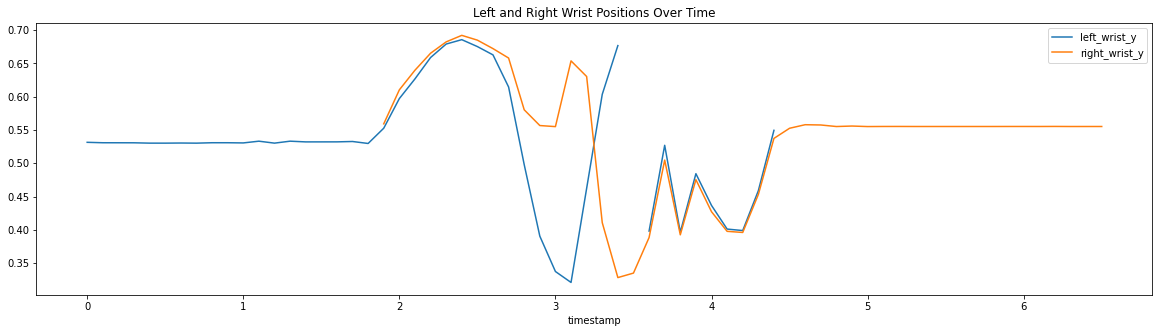

In [ ]:
plt.figure()
annotationsPd.plot('timestamp', ['left_wrist_y', 'right_wrist_y'], figsize=(20, 5))
plt.title("Left and Right Wrist Positions Over Time")
plt.savefig("wrist_pos")

The above plot is sort of useful, but what would be even better would be understanding the angles of my elbow, knee, etc. 

## Computing Angles
Step 1: let's create some classes for making working with points easier:

In [ ]:
class Point:
  def __init__(self, x, y):
    self.x = x
    self.y = y 

To compute the angle made by three points, we use the [Law of Cosines](https://www.google.com/search?q=rule+of+cosines&oq=rule+of+cosines&aqs=chrome.0.0l8.1048j1j7&sourceid=chrome&ie=UTF-8#wptab=s:H4sIAAAAAAAAAONgVuLQz9U3SMkuLnjE6Mgt8PLHPWEpi0lrTl5jNOLiCs7IL3fNK8ksqRRS4WKDsqS4eKTgmjQYpLi44DyeXUyCzvl5yakFJc6JOcmlOYkl-UWLWCV9EssV8tMUkvOLM_NSixWS4XIALyw914AAAAA). I did! Imagine a triangle with side lengths a, b, and c. Then, to find 𝛾 (the angle across from side c), the formula is:

\begin{equation*}
\gamma = \cos^{-1}\frac{a^2+b^2 - c^2}{2ab}
\end{equation*}

There's a good explanation and code sample [here](https://medium.com/@manivannan_data/find-the-angle-between-three-points-from-2d-using-python-348c513e2cd), from which this function is borrowed:

In [ ]:
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c.y-b.y, c.x-b.x) - math.atan2(a.y-b.y, a.x-b.x))
    return ang

Let's compute some useful angles below

In [ ]:
def computeElbowAngle(row, which='right'):
  wrist = Point(row[f'{which}_wrist_x'], row[f'{which}_wrist_y'])
  elbow = Point(row[f'{which}_elbow_x'], row[f'{which}_elbow_y'])
  shoulder = Point(row[f'{which}_shoulder_x'], row[f'{which}_shoulder_y'])
  return getAngle(wrist, elbow, shoulder)

def computeShoulderAngle(row, which='right'):
  elbow = Point(row[f'{which}_elbow_x'], row[f'{which}_elbow_y'])
  shoulder = Point(row[f'{which}_shoulder_x'], row[f'{which}_shoulder_y'])
  hip = Point(row[f'{which}_hip_x'], row[f'{which}_hip_y'])
  return getAngle(hip, shoulder, elbow)

def computeKneeAngle(row, which='right'):
  hip = Point(row[f'{which}_hip_x'], row[f'{which}_hip_y'])
  knee = Point(row[f'{which}_knee_x'], row[f'{which}_knee_y'])
  ankle = Point(row[f'{which}_ankle_x'], row[f'{which}_ankle_y'])
  return getAngle(ankle, knee, hip)

In [ ]:
# For a single timeslot...
row = annotationsPd.iloc[-1]
print("Elbow angle: " + str(computeElbowAngle(row)))
print("Shoulder angle: " + str(computeShoulderAngle(row)))
print("Knee angle: " + str(computeKneeAngle(row)))

Elbow angle: 110.81780784444196
Shoulder angle: -55.23295388257705
Knee angle: 228.31094094285586


Sweet! Now let's plot those angles over time.

In [ ]:
annotationsPd['right_elbow_angle'] = annotationsPd.apply(computeElbowAngle, axis=1)
annotationsPd['right_shoulder_angle'] = annotationsPd.apply(computeShoulderAngle, axis=1)
annotationsPd['right_knee_angle'] = annotationsPd.apply(computeKneeAngle, axis=1)

Now let's plot the results!

<Figure size 432x288 with 0 Axes>

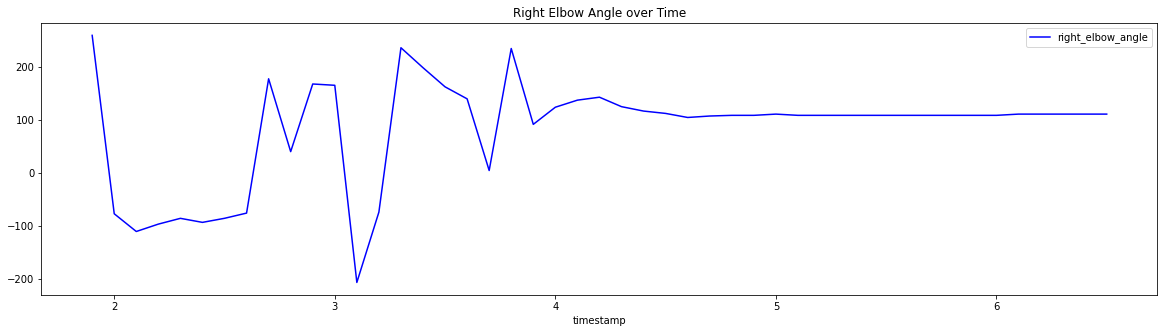

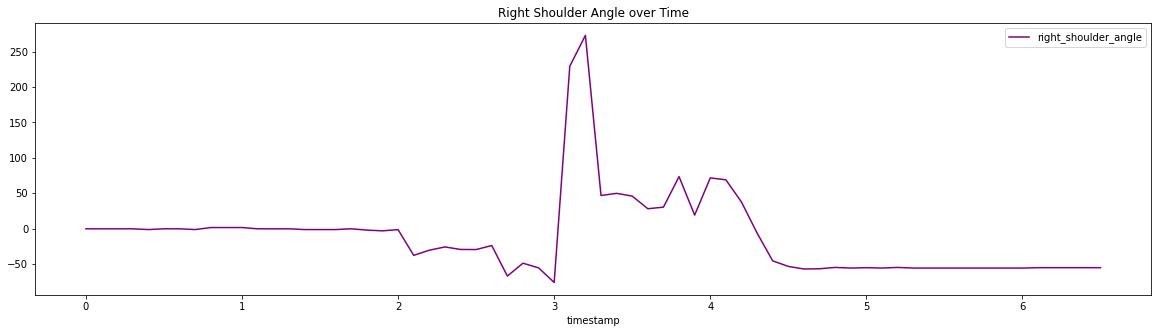

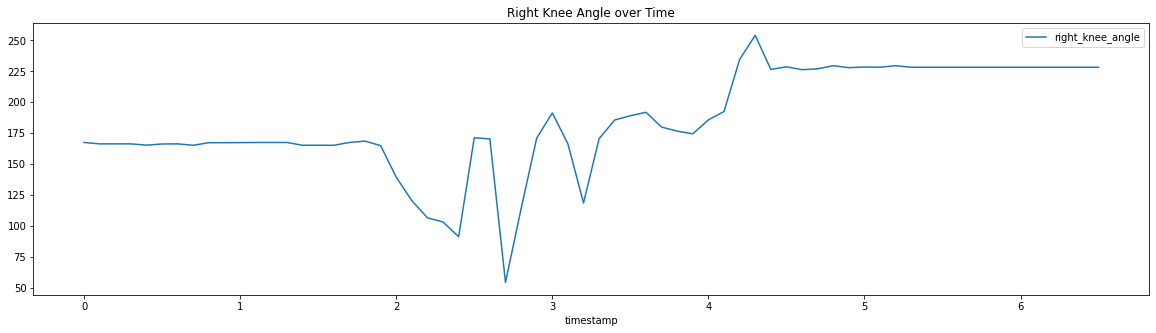

In [ ]:
plt.figure()
annotationsPd.plot('timestamp', ['right_elbow_angle'], figsize=(20, 5), color='blue')
plt.title("Right Elbow Angle over Time")
plt.savefig("right_elbow_angle")
annotationsPd.plot('timestamp', ['right_shoulder_angle'], figsize=(20, 5), color='purple')
plt.title("Right Shoulder Angle over Time")
plt.savefig("right_shoulder_angle")
annotationsPd.plot('timestamp', ['right_knee_angle'], figsize=(20, 5))
plt.title("Right Knee Angle over Time")
plt.savefig("right_knee_angle")

Now, these angles might not be very useful on their own. But, they can help us to deduce joint stress

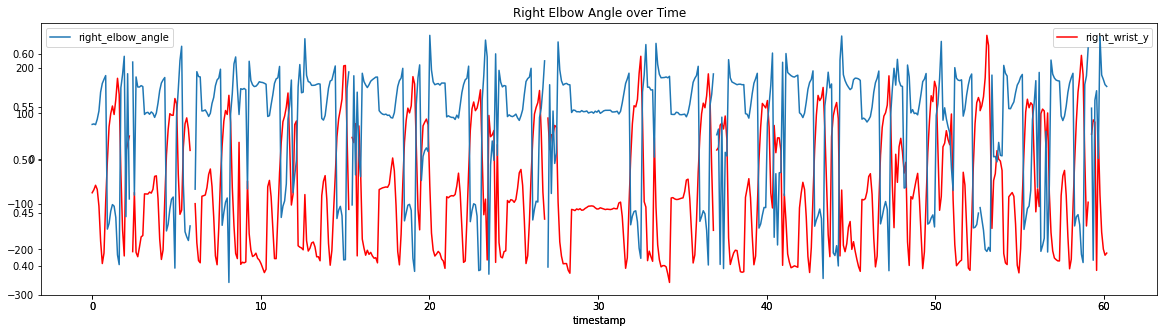

In [ ]:
fig = plt.figure()
ax=fig.add_subplot(111, label="1")
annotationsPd.plot('timestamp', ['right_wrist_y'], figsize=(20, 5), ax=ax, color='red')
plt.title("Right Elbow Angle over Time")

ax2=fig.add_subplot(111, label="2", frame_on=False)
annotationsPd.plot('timestamp', ['right_elbow_angle'], figsize=(20, 5), ax=ax2)

#annotationsPd.plot.scatter('right_wrist_y', 'right_elbow_angle')

# Deducing Joint Stress and Quantifying Injury Risk

In baseball pitching, the most common injury is that of the shoulder. Our goal is to measure the jerk/jolt (thrust). Similar to how someone can be injured due to the jerky whiplash of a car crash, a major injury can occur due to jerk (rapid acceleration, especially if repeated).

Here is the mathematical denotation for jerk: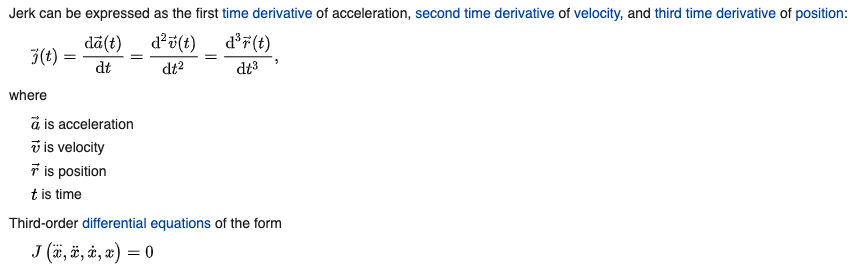

Since we have the position of the right shoulder over time. If we find the third derivative of that, that should correlate to jerk or injury risk. (the whiplash feeling of a pitch). Let's now get just the shoulder positions and times

In [ ]:
shoulder_positions = annotationsPd['right_shoulder_x']
times = annotationsPd['timestamp']

Rather than approximating derivatives through analytical techniques, we can use the UnivariateSpline function. 

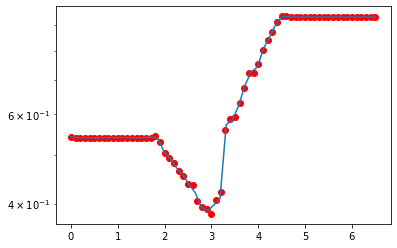

In [ ]:
from numpy import diff
x = times
y = shoulder_positions

# let's try fitting a graph to the position data

import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

y_spl = UnivariateSpline(x,y,s=0,k=4)

plt.semilogy(x,y,'ro',label = 'data')
x_range = np.linspace(0, 6.5)
plt.semilogy(x_range,y_spl(x_range))

This graph makes sense! A few seconds before and after the pitch, the shoulder position does not change! We can now take the third derivative with respect to time.

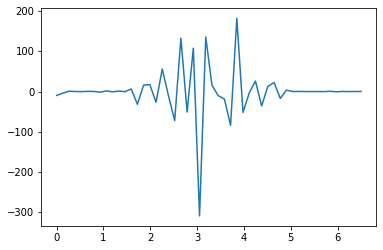

In [ ]:
y_spl_3d = y_spl.derivative(n=3)

plt.plot(x_range,y_spl_3d(x_range))


We did it! This graph quanitifes the jerk or joint stress over time. If pitches have high jerk (especially on multiple occasions), it can become a direct cause of injury! As you can see, at roughly 3 seconds, the shoulder had the highest jerk. If an injury or "tweak" occurs, it would most likely be at this time. To reduce injury risk during pitching, it is more important to smooth out this motion. In other words, prevent drastic minimas or maximas on this graph.